In [8]:
%reload_ext autoreload
%autoreload 2

## Modellisation du problème

Dans le cadre de l'étude de l'évolution d'une pandémie comme celle du Covic-19, nous utilisons une représentation de l'état basée sur le modèle SEIR défini dans le papier [Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study](https://www.thelancet.com/action/showPdf?pii=S0140-6736%2820%2930260-9).

Ce modèle présente un état sous forme de 4-uplet avec les éléments :
- S : Le nombre de personnes de la population susceptibles d'être atteintes par la maladie.
- E : Le nombre de personnes exposées par la maladie, qui en sont porteurs mais qui n'ont pas encore les symptômes.
- I : Le nombre de personnes infectées par la maladie, qui sont susceptible de la transmettre.
- R : Le nombre de persones rétablies, que l'on considère immunisées par la maladie. Celà peut dépendre aussi de la vaccination.
- D : Le nombre de personnes décédées par la maladie.

Le modèle SIR existe aussi mais nous avons voulu ajouter l'état E car une transmission non immédiate nous semble plus pertinente suite à l'expérience du Covid-19 qui pouvait montrer des périodes d'incubation jusqu'à une semaine. Nous pourrions aussi ajouter une évolution de la taille de la population par exemple suite à des décès dûes à l'infection, mais en première approximation, nous ne prendront pas en compte cette possibilité.

Le fait d'ajouter les décès propose une réflexion qui nous semble nécessaire pour considérer une évolution de population $$N(t) = S(t) + E(t) + I(t) + R(t) + D(t)$$ avec $N(0)=N_0=1$ et $D(0)=D_0=0$.

Nous nous inspirons du projet cité précédemment, où nous ne prenons pas en compte les voyageurs (L dans le papier) et l'infection animale z.

Les équations régissant notre problème deviennent :

$$\begin{aligned}
\frac{dS}{dt} &= -\beta (1 - u_{conf}) S I - u_{vacc} S \\
\frac{dE}{dt} &= \beta (1 - u_{conf}) S I - \sigma E \\
\frac{dI}{dt} &= \sigma E - \gamma I \\
\frac{dR}{dt} &= \gamma (1 - \mu) I + u_{vacc} S \\
\frac{dD}{dt} &= \gamma \mu I
\end{aligned}$$

où 
- $\beta$ (Taux de transmission sans confinement).
- $\sigma$ (Taux d'incubation) : 1/ temps d'incubation
- $\gamma$ (Taux de guérison) : 1/ temps de guérison
- $\mu$ (Taux de mortalité)
- $R_0$ (Taux de reproduction de base) : $\beta / \gamma$.

Notre contrôle, ce sur quoi nous avons un impact est :
- $u_{conf}$ : le niveau de confinement entre 0 et 1. 0 correspond au fonctionnement normal et 1 à un confinement total de la population. Nous le confondons avec le niveau d'intention proposé dans le sujet.
- $u_{vacc}$ : le taux de vaccination entre 0 et 1. Celà permet de considérer une partie de la population S comme rétablie (R).

## Références :
- [Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study](https://www.thelancet.com/action/showPdf?pii=S0140-6736%2820%2930260-9)
- [Reinforcement learning-based decision support system for COVID-19](https://www-sciencedirect-com.bases-doc.univ-lorraine.fr/science/article/pii/S1746809421002731)

---------------------------
## Implementation

In [9]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from model import SEIREnv, ProblemConfig


Tout d'abord, nous instancions les paramètres de notre modèle. Les valeurs choisies suivent l'article publié dans The Lancet.
Dans leur étude, ils indiquent un taux de reproduction de base $R_0$ estimé à $2,68$. Nous proposons $2,7$ pour la suite. Puisque cette valeur correspond à $\beta / \gamma$, nous proposons un temps de guérison de la maladie de 10 jours (ce qui correspond à peu prêt à notre propre expérience du confinement), ce qui indique $\gamma = 0.1$. Cela nous impose donc $\beta = 0.27$. En nous basant sur les confinements imposés pour les cas contact durant la pandémie, nous estimons à 7 jours le temps d'incubation de la maladie, soit $\sigma = 1/7 \approx 0.14$. 

Nous choisissons un pas de temps $dt=1$ pour 1 jours d'avancée.

In [10]:
# Les valeurs par défaut de ProblemConfig correspondent maintenant aux paramètres COVID-19
# beta=0.27 (R0 ≈ 2.7), sigma=0.14 (7j incubation), gamma=0.1 (10j guérison)
# On utilise les valeurs par défaut
from model import ProblemConfig
config = ProblemConfig()
print(f"R0 = β/γ = {config.beta / config.gamma:.2f}")

R0 = β/γ = 2.70


### Fonction de coût
Afin de quantifier l'impact socio-économique des politiques publiques mises en place, nous nous inspirons des choix faits par le gourvernement français durant les années 2016-2020. Pour cela,

In [11]:
# On instancie l'environnement avec la configuration
env = SEIREnv(config)

# Vérification rapide que l'environnement respecte les standards Gym
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)
print("Environnement validé !")

Environnement validé !


/home/csutty/miniconda3/envs/rlearning/lib/python3.13/site-packages/stable_baselines3/common/env_checker.py:507: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [12]:
# Définition du modèle PPO
# MlpPolicy = Réseau de neurones classique (Multi Layer Perceptron)
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, gamma=0.99)

print("Début de l'entraînement...")
# 50 000 timesteps devraient suffire pour voir une convergence sur ce problème simple
model.learn(total_timesteps=50000)
print("Entraînement terminé.")

# Sauvegarde du modèle (pour le rapport)
model.save("ppo_seir_covid")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Début de l'entraînement...
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 221       |
|    ep_rew_mean     | -4.46e+03 |
| time/              |           |
|    fps             | 667       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 225         |
|    ep_rew_mean          | -4.23e+03   |
| time/                   |             |
|    fps                  | 589         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012804313 |
|    clip_fraction        | 0.158       |
|    clip_range         

In [13]:
def run_simulation(env, model=None):
    """
    Lance une simulation.
    Si model est None, on ne fait rien (Laissez-faire).
    Sinon, on utilise l'agent entraîné.
    """
    obs, _ = env.reset()
    done = False

    history = {"S": [], "E": [], "I": [], "R": [], "D": [], "Conf": [], "Vacc": [], "Reward": []}

    while not done:
        if model:
            action, _ = model.predict(obs, deterministic=True)
        else:
            action = [0.0, 0.0]  # Aucune action (Laissez-faire)

        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Enregistrement pour les graphes
        history["S"].append(obs[0])
        history["E"].append(obs[1])
        history["I"].append(obs[2])
        history["R"].append(obs[3])
        history["D"].append(obs[4])
        if model:
            history["Conf"].append(action[0])
            history["Vacc"].append(action[1])
        else:
            history["Conf"].append(0)
            history["Vacc"].append(0)

        history["Reward"].append(reward)

    return history


# Lancer les deux scénarios avec la même configuration
env_eval = SEIREnv(config)
history_rl = run_simulation(env_eval, model)
history_no_action = run_simulation(env_eval, model=None)

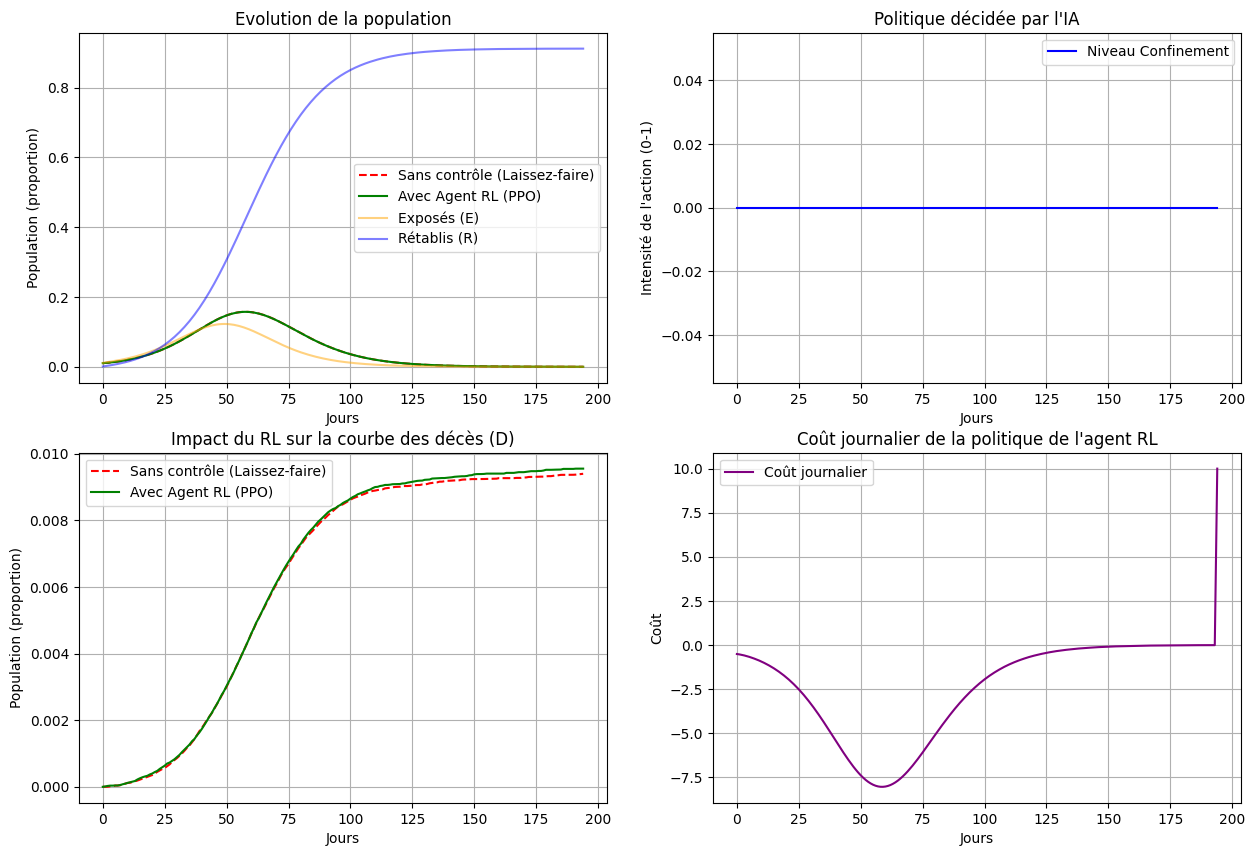

In [ ]:
# Création des graphiques
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Graphique 1 : Comparaison des Infectés (Courbe épidémique)
ax1.plot(
    history_no_action["I"],
    label="Sans contrôle (Laissez-faire)",
    linestyle="--",
    color="red",
)
ax1.plot(history_rl["I"], label="Avec Agent RL (PPO)", color="green")
ax1.plot(history_rl["E"], label="Exposés (E)", color="orange", alpha=0.5)
ax1.plot(history_rl["R"], label="Rétablis (R)", color="blue", alpha=0.5)
ax1.set_title("Evolution de la population")
ax1.set_xlabel("Jours")
ax1.set_ylabel("Population (proportion)")
ax1.legend()
ax1.grid(True)

# Graphique 2 : Stratégie de l'Agent
ax2.plot(history_rl["Conf"], label="Niveau Confinement", color="blue")
ax2.plot(history_rl["Vacc"], label="Taux Vaccination", color="orange")
ax2.set_title("Politique décidée par l'IA")
ax2.set_xlabel("Jours")
ax2.set_ylabel("Intensité de l'action (0-1)")
ax2.legend()
ax2.grid(True)

# Graphique 3 : Comparaison des Décès
ax3.plot(
    history_no_action["D"],
    label="Sans contrôle (Laissez-faire)",
    linestyle="--",
    color="red",
)
ax3.plot(history_rl["D"], label="Avec Agent RL (PPO)", color="green")
ax3.set_title("Impact du RL sur la courbe des décès (D)")   
ax3.set_xlabel("Jours")
ax3.set_ylabel("Population (proportion)")
ax3.legend()
ax3.grid(True)

ax4.plot(history_rl["Reward"], label="Coût journalier", color="purple")
ax4.set_title("Coût journalier de la politique de l'agent RL")
ax4.set_xlabel("Jours")
ax4.set_ylabel("Coût")
ax4.legend()
ax4.grid(True)

plt.show()
